In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('..')
from src.data_augmentation import *
from src.folder_preparation import *
import seaborn as sns
from tensorflow.keras import layers
import sklearn.metrics as metrics

### resize and move data into folders with train and validation subdirectories
#### <font color='red'> only run once!</font>

In [36]:
target_dir = Path('../data-only-oranges')
dest_dir = Path('split_data-only-oranges')
resize_and_move_images_to_train_val_folders(target_dir=target_dir,
                                           dest_dir=dest_dir,
                                           split_ratio=0.1,
                                           image_format='.png',
                                           target_size=255)

### create dataset

In [4]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
batch_size = 4
img_height = 255
img_width = 192

In [6]:
train_dir = Path('./split_data-only-oranges/train')
val_dir = Path('./split_data-only-oranges/validation')

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

Found 965 files belonging to 10 classes.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 112 files belonging to 10 classes.


### visualize the data

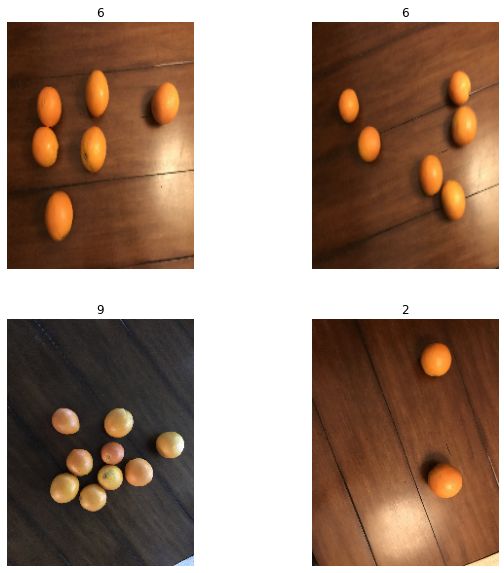

In [9]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### standardize data

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))

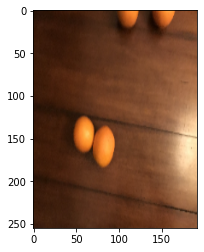

In [12]:
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
plt.imshow(first_image)

### configure dataset for performance

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### train a model

In [15]:
num_classes = 10
model = tf.keras.Sequential([
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

In [16]:
# model.compile(
#     optimizer='adam',
#     loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics = ['accuracy']
# )

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [18]:
normalized_train_ds

<MapDataset shapes: ((None, 255, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [19]:
print('{} train and {} val before ignoring errors'.format(len(train_ds),
                                                          len(val_ds)))
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds = val_ds.apply(tf.data.experimental.ignore_errors())
print('{} train and {} val after ignoring errors'.format(len(train_ds)
                                                          ,len(val_ds)))

242 train and 28 val before ignoring errors
242 train and 28 val after ignoring errors


In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
242/242 [==============================] - 20s 82ms/step - loss: -56.8101 - accuracy: 0.0539 - val_loss: -59.7716 - val_accuracy: 0.0536
Epoch 2/3
242/242 [==============================] - 19s 77ms/step - loss: -60.3807 - accuracy: 0.0528 - val_loss: -59.7716 - val_accuracy: 0.0536
Epoch 3/3
242/242 [==============================] - 18s 76ms/step - loss: -60.3807 - accuracy: 0.0528 - val_loss: -59.7716 - val_accuracy: 0.0536


### model evaluation

In [21]:
predictions = model.predict_generator(val_ds)

Instructions for updating:
Please use Model.predict, which supports generators.


In [22]:
predicted_classes = np.argmax(predictions, axis=1)

In [23]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [24]:
labels = np.array([x[1].numpy() for x in list(val_ds)])

In [25]:
ground_truth = np.array(list(np.concatenate(labels, axis=0 )))

In [26]:
confusion_matrix = metrics.confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)  # shape=(12, 12)

In [27]:
cm_labels = list(np.sort(list(map(int,class_names))))

In [28]:
import pandas as pd

In [29]:
df_cm = pd.DataFrame(confusion_matrix,columns=cm_labels,index = cm_labels)

Text(0.5, 1.0, 'Confusion matrix')

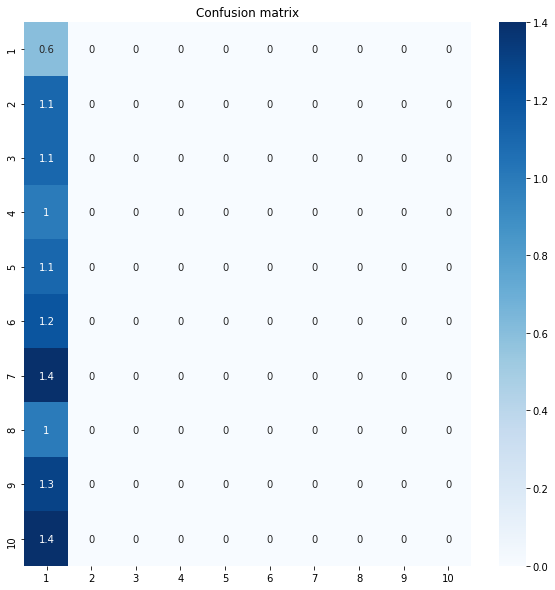

In [30]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cm/len(df_cm),
           cmap='Blues',
           annot=True)
plt.title('Confusion matrix')

### visualizing training history

In [31]:
history.history

{'loss': [-56.81005859375, -60.38065719604492, -60.38065719604492],
 'accuracy': [0.053886011242866516, 0.05284973978996277, 0.05284973978996277],
 'val_loss': [-59.77157211303711, -59.77157211303711, -59.77157211303711],
 'val_accuracy': [0.0535714291036129, 0.0535714291036129, 0.0535714291036129]}

In [32]:
epochs = 3
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


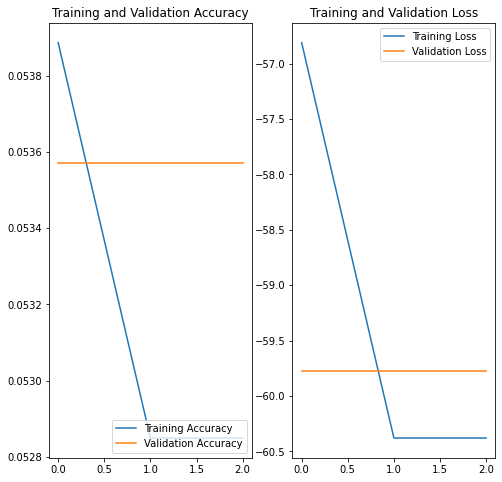

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()